# Time-frequency analysis
This notebook re-analyzes and extracts power from the 
resting state???

- which method to use: Hilbert-filter, complex morlet wavelet convolution, Short-time FFT (Welch), Multitapers
- If we use Welch method what is the size of the fft window? should we have zero paddings? should we have overlap? what to do for the edge artefacts?
- Normalization: which method to use? Z transform, percentage change or decibels? which part of the recording should be used as the baseline? which baseline window is the best?

In [27]:
def _cut_noisy(raw, task, language):
    """
    First step of preprocessing in my pipeline!
    it's important to get rid of noisy parts in baseline and experinece segments: informed from the audio files.

    Parameters
    ----------
    raw : mne.io.Raw
        eeg raw data
    task : str
        can be experience1, etc or baseline1 or baseline2
    language : str
        language of the experiment ['eng' or 'hun']
    """
    # validate task and language name
    import re
    from collections import namedtuple

    if not re.fullmatch('(baseline[12])|(experience[1-4])', task):
        raise Exception('Invalid task!')

    tasklang = task + language

    # helper named tuple to make the code more readable
    Interval = namedtuple('Interval', ['tmin', 'tmax'])

    cut_intervals = {
        '(experience[1-4](eng|hun))|baseline1hun': Interval(tmin=20, tmax=320),
        'baseline1eng': Interval(tmin=25, tmax=325),
        'baseline2(eng|hun)': Interval(tmin=30, tmax=330),
        }
    interval = [value for key, value in cut_intervals.items() if re.fullmatch(key, tasklang)][0]

    raw.crop(tmin=interval.tmin, tmax=interval.tmax)

    return raw

In [4]:
# setup
import mne
import numpy as np
import pandas as pd
import os.path as op
import matplotlib.pyplot as plt
import mne_bids
from mne.time_frequency import psd_welch
# from autoreject import get_rejection_threshold
# from preprocessing import _epochs_to_continuous, _make_montage
# from xarray_creator import _cut_noisy

# open preprocessed data
# n_sub = '01'
# task = 'induction1'
# con_dict = {}
# data_dir = 'data/clean_data'
# 'sub-01_ses-01_task-induction4_epo.fif'
# epoch_name = f'sub-{n_sub}_ses-01_task-{task}_epo.fif'
# dir = op.join(data_dir, epoch_name)

# # open clean epochs
# epoch = mne.read_epochs(dir)
# raw = mne.read_epochs(dir)

In [8]:
from mne.time_frequency import psd_welch
psd, _ = psd_welch(raw, n_fft=1051, n_per_seg=1051, fmax=40)

Effective window size : 1.051 (s)


## The impact of different parameters on welch method
Below image shows is that if we use epoched data and then average over the epoch dimention is the same as we concatenate epochs and then calculate the psd using Welch method.

In [2]:
bids_path = mne_bids.BIDSPath(subject='01', session='01', task='baseline1', root='data/BIDS_data')
raw = mne_bids.read_raw_bids(bids_path, verbose=False)
# raw = _cut_noisy(raw, 'baseline1', 'hun')
raw.load_data().filter(0.5, 42, h_trans_bandwidth='auto')
# pos = _make_montage()
# raw.set_montage(pos)

epochs = mne.make_fixed_length_epochs(raw, duration=1)
# reject = get_rejection_threshold(epochs)
# epochs.drop_bad(reject=reject)
# data = _epochs_to_continuous(epochs)
# info = mne.create_info(ch_names=raw.ch_names, sfreq=1000, ch_types='eeg')
# raw2 = mne.io.RawArray(data, info)
# raw2.set_channel_types({'ECG':'ecg',
#                        'EOG1':'eog',
# #                        'EOG2':'eog'})
# raw2.set_montage(pos)
# raw2.pick_types(eeg=True)

Extracting parameters from data/BIDS_data/sub-01/ses-01/eeg/sub-01_ses-01_task-baseline1_eeg.vhdr...
Setting channel info structure...
Reading events from data/BIDS_data/sub-01/ses-01/eeg/sub-01_ses-01_task-baseline1_events.tsv.
Reading channel info from data/BIDS_data/sub-01/ses-01/eeg/sub-01_ses-01_task-baseline1_channels.tsv.
Reading 0 ... 333580  =      0.000 ...   333.580 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 42 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 42.00 Hz
- Upper transition bandwidth: 10.50 Hz (-6 dB cutoff frequency: 47.25 Hz)
- Filter length: 6601 samples (6.601 sec)

Not setting metadata
Not setting metadata
333 

In [17]:
psds_welch_concatenated, freqs_median = psd_welch(raw, **kwargs)
psds_welch_concatenated = 10. * np.log10(psds_welch_concatenated)
psds_welch_concatenated = psds_welch_concatenated.mean(0)
psds_welch_concatenated

Effective window size : 1.000 (s)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.6s remaining:    1.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.7s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.8s finished


array([[-121.54787559, -124.58502431, -126.19073461, ..., -128.78153257,
        -129.0155386 , -129.2597346 ],
       [-120.67487882, -124.10390873, -125.62990388, ..., -126.89432561,
        -127.05771763, -127.3329816 ],
       [-120.32561669, -123.53133484, -124.06361254, ..., -122.27862073,
        -122.66937986, -122.65986749],
       ...,
       [-118.10734077, -120.79237689, -122.1449324 , ..., -131.88907321,
        -132.67882032, -133.10121533],
       [-118.25247073, -121.603637  , -123.26744083, ..., -132.26924712,
        -133.58716617, -133.25898229],
       [-118.89900726, -121.51997543, -122.43463921, ..., -133.84260837,
        -133.995091  , -134.53661044]])

Loading data for 333 events and 1000 original time points ...
Effective window size : 1.000 (s)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Loading data for 333 events and 1000 original time points ...


[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    5.2s remaining:    8.7s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    5.3s remaining:    3.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.3s finished


Effective window size : 0.256 (s)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.9s remaining:    1.6s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    1.1s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.1s finished


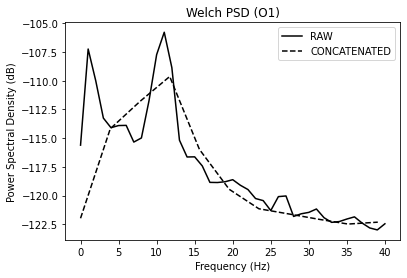

In [33]:
# kwargs = dict(fmin=2, fmax=40, n_jobs=-1, n_fft=1000, n_overlap=0)
psds_welch_epoch, freqs_mean = psd_welch(epochs, n_fft=1000, fmax=40, n_jobs=-1)
psds_welch_epoch = psds_welch_epoch.mean(0)
psds_welch_concatenated, freqs_median = psd_welch(epochs, n_fft=256, fmax=40, n_jobs=-1)
psds_welch_concatenated = psds_welch_concatenated.mean(0)

# Convert power to dB scale.
psds_welch_epoch = 10 * np.log10(psds_welch_epoch)
psds_welch_concatenated = 10 * np.log10(psds_welch_concatenated)

# We will only plot the PSD for a single sensor in the first epoch.
ch_name = 'O1'
ch_idx = raw.info['ch_names'].index(ch_name)

_, ax = plt.subplots()
ax.plot(freqs_mean, psds_welch_epoch[ch_idx, :], color='k',
        ls='-', label='RAW')
ax.plot(freqs_median, psds_welch_concatenated[ch_idx, :], color='k',
        ls='--', label='CONCATENATED')

ax.set(title='Welch PSD ({})'.format(ch_name),
       xlabel='Frequency (Hz)', ylabel='Power Spectral Density (dB)')
ax.legend(loc='upper right')
plt.show()

Effective window size : 1.000 (s)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.6s remaining:    1.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.7s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.7s finished


Effective window size : 1.000 (s)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.6s remaining:    1.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.7s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.8s finished


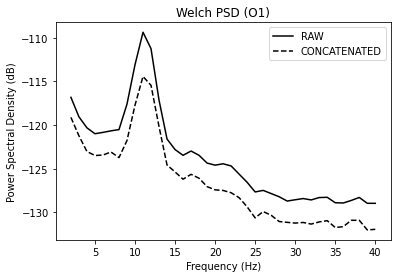

In [20]:
# examining the order of transformation and averaging

kwargs = dict(fmin=2, fmax=40, n_jobs=-1, n_fft=1000, n_overlap=0)
psds_welch_epoch, freqs_mean = psd_welch(raw, **kwargs)
psds_welch_epoch = psds_welch_epoch.mean(0)
psds_welch_epoch = 10. * np.log10(psds_welch_epoch)
psds_welch_concatenated, freqs_median = psd_welch(raw, **kwargs)
psds_welch_concatenated = 10. * np.log10(psds_welch_concatenated)
psds_welch_concatenated = psds_welch_concatenated.mean(0)

# We will only plot the PSD for a single sensor
ch_name = 'O1'
ch_idx = raw.info['ch_names'].index(ch_name)

_, ax = plt.subplots()
ax.plot(freqs_mean, psds_welch_epoch[ch_idx, :], color='k',
        ls='-', label='RAW')
ax.plot(freqs_median, psds_welch_concatenated[ch_idx, :], color='k',
        ls='--', label='CONCATENATED')

ax.set(title='Welch PSD ({})'.format(ch_name),
       xlabel='Frequency (Hz)', ylabel='Power Spectral Density (dB)')
ax.legend(loc='upper right')
plt.show()

In [28]:
# n_sub = '10'
# task = 'induction1'
# epo_name = f'sub-{n_sub}_ses-01_task-{task}_proc-clean_epo.fif'
# dir = op.join('data/clean_data', epo_name)
# # open clean epochs
# epochs = mne.read_epochs(dir)

bids_path = mne_bids.BIDSPath(subject='01', session='01', task='baseline1', root='data/BIDS_data')
raw = mne_bids.read_raw_bids(bids_path, verbose=False)
raw.load_data().filter(0.5, 42, h_trans_bandwidth='auto')
raw = _cut_noisy(raw, 'baseline1', 'hun')

epochs_base = mne.make_fixed_length_epochs(raw, duration=1)

bids_path = mne_bids.BIDSPath(subject='01', session='01', task='experience1', root='data/BIDS_data')
raw = mne_bids.read_raw_bids(bids_path, verbose=False)
raw.load_data().filter(0.5, 42, h_trans_bandwidth='auto')
raw = _cut_noisy(raw, 'experience1', 'hun')

epochs = mne.make_fixed_length_epochs(raw, duration=1)

Extracting parameters from data/BIDS_data/sub-01/ses-01/eeg/sub-01_ses-01_task-baseline1_eeg.vhdr...
Setting channel info structure...
Reading events from data/BIDS_data/sub-01/ses-01/eeg/sub-01_ses-01_task-baseline1_events.tsv.
Reading channel info from data/BIDS_data/sub-01/ses-01/eeg/sub-01_ses-01_task-baseline1_channels.tsv.
Reading 0 ... 333580  =      0.000 ...   333.580 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 42 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 42.00 Hz
- Upper transition bandwidth: 10.50 Hz (-6 dB cutoff frequency: 47.25 Hz)
- Filter length: 6601 samples (6.601 sec)

Not setting metadata
Not setting metadata
300 

Extracting parameters from data/BIDS_data/sub-01/ses-01/eeg/sub-01_ses-01_task-baseline1_eeg.vhdr...
Setting channel info structure...
Reading events from data/BIDS_data/sub-01/ses-01/eeg/sub-01_ses-01_task-baseline1_events.tsv.
Reading channel info from data/BIDS_data/sub-01/ses-01/eeg/sub-01_ses-01_task-baseline1_channels.tsv.
Reading 0 ... 333580  =      0.000 ...   333.580 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 42 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 42.00 Hz
- Upper transition bandwidth: 10.50 Hz (-6 dB cutoff frequency: 47.25 Hz)
- Filter length: 6601 samples (6.601 sec)

Not setting metadata
Not setting metadata
300 

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Loading data for 300 events and 1000 original time points ...


[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.7s remaining:    1.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.8s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.9s finished


0 bad epochs dropped
Effective window size : 1.000 (s)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.6s remaining:    1.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.7s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.9s finished


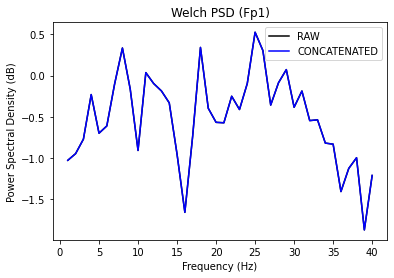

In [54]:
# compare normalized with non-normalized data
# open psd data
bids_path = mne_bids.BIDSPath(subject='01', session='01', task='baseline1', root='data/BIDS_data')
raw = mne_bids.read_raw_bids(bids_path, verbose=False)
raw.load_data().filter(0.5, 42, h_trans_bandwidth='auto')
raw = _cut_noisy(raw, 'baseline1', 'hun')
epochs_base = mne.make_fixed_length_epochs(raw, duration=1)

bids_path = mne_bids.BIDSPath(subject='01', session='01', task='experience1', root='data/BIDS_data')
raw = mne_bids.read_raw_bids(bids_path, verbose=False)
raw.load_data().filter(0.5, 42, h_trans_bandwidth='auto')
raw = _cut_noisy(raw, 'experience1', 'hun')
epochs = mne.make_fixed_length_epochs(raw, duration=1) 

kwargs = dict(fmin=4, fmax=8, n_jobs=-1, n_fft=1000)
psds_welch_epoch, freqs_mean = psd_welch(epochs, n_overlap=0, **kwargs)
psds_welch_epoch = psds_welch_epoch.mean(0)
psds_welch_concatenated, freqs_median = psd_welch(epochs_base, n_overlap=0, **kwargs)
psds_welch_concatenated = psds_welch_concatenated.mean(0)

# Convert power to dB scale.
a = 10 * np.log10(psds_welch_epoch / psds_welch_concatenated)
psds_welch_epoch = 10 * np.log10(psds_welch_epoch)
psds_welch_concatenated = 10 * np.log10(psds_welch_concatenated)
b = psds_welch_epoch - psds_welch_concatenated
# We will only plot the PSD for a single sensor in the first epoch.
ch_name = 'Fp1'
ch_idx = raw.info['ch_names'].index(ch_name)

_, ax = plt.subplots()
ax.plot(freqs_mean, a[ch_idx, :], color='k',
        ls='-', label='RAW')
ax.plot(freqs_median, b[ch_idx, :], color='b',
        ls='-', label='CONCATENATED')

ax.set(title='Welch PSD ({})'.format(ch_name),
       xlabel='Frequency (Hz)', ylabel='Power Spectral Density (dB)')
ax.legend(loc='upper right')
plt.show()

In [ ]:
# long to wide format
# open the power
power = pd.read_excel('docs/psds_new.xlsx', index_col='Unnamed: 0', header=1)
power.columns = power.columns.str.replace('lower_gamma', 'lowergamma')
_power = power.copy()
_power[['subject', 'condition']] = _power.index.to_series().apply(lambda x:x.split('-')).apply(pd.Series)
_power = _power.pivot(index='subject', columns='condition')
_power.columns = [f'{c[0]}_{c[1]}' for c in _power.columns]

# open behavioral data and join
bh = pd.read_csv('docs/plb_hyp_data.csv', index_col='index')
ids_map = pd.read_excel('docs/ids_map.xlsx', header=1, index_col='behavioral_id')
ids_map = ids_map.drop_duplicates('bids_id')
ids_map = ids_map[['bids_id']]
ids_map['bids_id'] = ids_map['bids_id'].apply(lambda x:str(x).zfill(2))
_bh = bh.join(ids_map, how='right')
df_merged = pd.merge(_bh, _power, left_on='bids_id', right_index=True)
df_merged.to_csv('data/data_with_power.csv')